In [63]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
import os
import PIL
import imageio # dependencies: Numpy, Pillow
import cv2

from PIL import Image
from tifffile import imread
from tifffile import imwrite
from csbdeep.utils import plot_some
from csbdeep.utils.tf import limit_gpu_memory
from csbdeep.data import RawData, create_patches_reduced_target

In [7]:
limit_gpu_memory(fraction=1/2)

In [73]:
# preprocess images
#------------------------------------------------------------------------------------------------------------------------
# groundtruth

def StackRGB(shape, IM):
    channel2 = shape[2]
    if channel2 <=4: #RGB
        channelofI = IM[:, :, 1] #change channel number if channel for correlation of light microscopic image differs
    else: #stack
        channelofI = IM[0, :, :]
    return channelofI

GTdirectory = '/home/s353960/programs/Daten_Elektronenmikroskopie/fluo2_Chromatin_Celegans/'
Xdirectory = '/home/s353960/programs/Daten_Elektronenmikroskopie/fluo_input_tif_greyscale/'
#os.mkdir(Xdirectory) # comment out if directory exists already

print('groundtruth--------------------------------------------------')
for filename in os.listdir(GTdirectory): #generates list with names of the entries in the directory
    if filename.endswith('.png'): #returns true if string ends with .tif or .tiff
        GTpath = os.path.join(GTdirectory, filename) # join path components intelligently
        IM = imageio.imread(GTpath)
        dimension = IM.ndim
        shape = IM.shape
        if dimension >= 3: #RGB image or stack
            channelofI = StackRGB(shape, IM)
        else: # greyscale
            channelofI = IM
        GT = channelofI
        GT = GT[:925, :] #uncomment if groundtruth image should be cropped [y, x]
        GT = cv2.resize(GT, dsize=(256, 256), interpolation=cv2.INTER_LINEAR)
        name, ext = os.path.splitext(filename) # split filname in name and extension (ext)
        writepath = os.path.join(Xdirectory, name + '.tif')
        imwrite(writepath, GT)
        print(filename + ': processed')
        text = 'shape: %s to  %s' % (shape, GT.shape)
        print(text)
        print(' ')

#------------------------------------------------------------------------------------------------------------------------
#input
IPdirectory = '/home/s353960/programs/Daten_Elektronenmikroskopie/rem2_Chromatin_Celegans/'
Ydirectory = '/home/s353960/programs/Daten_Elektronenmikroskopie/rem_input_tifstack_greyscale/'
#os.mkdir(Ydirectory) # comment out if directory exists already
# stack or RGB

def StackRGB(shape, IM):
    channel2 = shape[2]
    if channel2 <=4: #RGB
        channelofI = IM[:, :, 1] #change channel number if channel for correlation of electron microscopic image differs
    else: #stack
        channelofI = IM[0, :, :]
    return channelofI

print('input--------------------------------------------------------')
for filename in os.listdir(IPdirectory): #generates list with names of the entries in the directory
    if filename.endswith('.png'): #returns true if string ends with .tif or .tiff
        IPpath = os.path.join(IPdirectory, filename) # join path components intelligently
        IM = imageio.imread(IPpath)
        dimension = IM.ndim
        shape = IM.shape
        if dimension >= 3: #RGB image or stack
            channelofI = StackRGB(shape, IM)
        else: # greyscale
            channelofI = IM
        channelofI = channelofI[:925, :] #uncomment if input image should be cropped [y, x]
        channelofI = cv2.resize(channelofI, dsize=(256, 256), interpolation=cv2.INTER_LINEAR)
        IP = np.stack((channelofI, channelofI), axis = 0)
        name, ext = os.path.splitext(filename) # split filname in name and extension (ext)
        writepath = os.path.join(Ydirectory, name + '.tif')
        imwrite(writepath, IP)
        print(filename + ': processed')
        text = 'shape: %s to  %s' % (shape, IP.shape)
        print(text)
        print(' ')

groundtruth--------------------------------------------------
A1S3_U.png: processed
shape: (1024, 1281, 4) to  (256, 256)
 
A2S6_U.png: processed
shape: (996, 1248, 4) to  (256, 256)
 
A1S2_U.png: processed
shape: (1022, 1276, 4) to  (256, 256)
 
A2S7_U.png: processed
shape: (1011, 1251, 4) to  (256, 256)
 
A1S10_U.png: processed
shape: (1027, 1281, 4) to  (256, 256)
 
A2S8_U.png: processed
shape: (1019, 1263, 4) to  (256, 256)
 
A2S4_U.png: processed
shape: (1022, 1278, 4) to  (256, 256)
 
A1S1_U.png: processed
shape: (1012, 1263, 4) to  (256, 256)
 
A2S9_U.png: processed
shape: (1006, 1253, 4) to  (256, 256)
 
A2S5_U.png: processed
shape: (1017, 1253, 4) to  (256, 256)
 
A2S11_U.png: processed
shape: (994, 1242, 4) to  (256, 256)
 
A1S7_U.png: processed
shape: (1008, 1262, 4) to  (256, 256)
 
A2S2_U.png: processed
shape: (1019, 1274, 4) to  (256, 256)
 
A2S10_U.png: processed
shape: (997, 1246, 4) to  (256, 256)
 
A1S6_U.png: processed
shape: (997, 1249, 4) to  (256, 256)
 
A2S3_U.pn

input  image size = (2, 256, 256)
output image size = (256, 256)


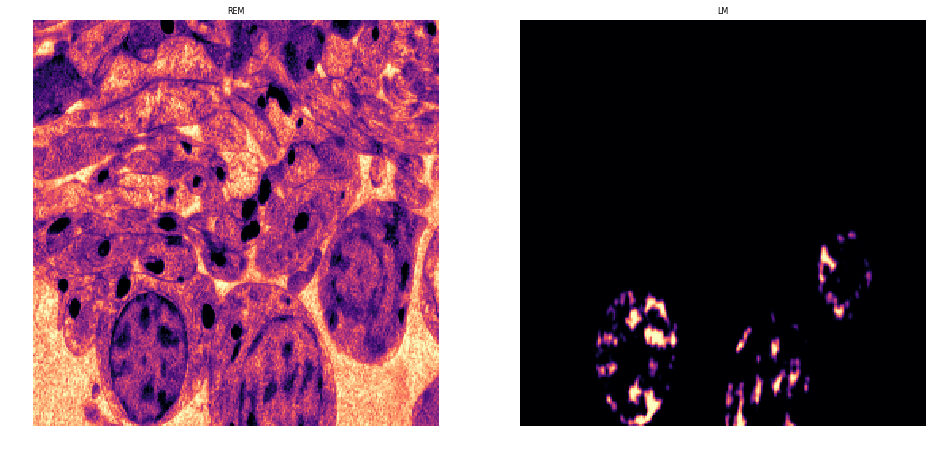

In [74]:
y = imread('/home/s353960/programs/Daten_Elektronenmikroskopie/fluo_input_tif_greyscale/S3.tif') # 16 bit greyscale tif as groundtruth
x = imread('/home/s353960/programs/Daten_Elektronenmikroskopie/rem_input_tifstack_greyscale/S3.tif') # 16 bit greyscale tif stack (2) as input
print('input  image size =', x.shape)
print('output image size =', y.shape)
plt.figure(figsize=(16,10))
plot_some(np.stack([x,np.broadcast_to(y,x.shape)]),
          title_list=[['REM','LM']], 
          pmin=2,pmax=99.8);

In [75]:
raw_data = RawData.from_folder (
    basepath    = '/home/s353960/programs/Daten_Elektronenmikroskopie',
    source_dirs = ['rem_input_tifstack_greyscale'],
    target_dir  = 'fluo_input_tif_greyscale',
    axes        = 'ZYX',
)

In [78]:
X, Y, XY_axes = create_patches_reduced_target (
    raw_data            = raw_data,
    patch_size          = (None,128,128),
    n_patches_per_image = 16,
    target_axes         = 'YX',
    reduction_axes      = 'Z',
    save_file           = '/home/s353960/programs/Daten_Elektronenmikroskopie/rem_input_tifstack_greyscale/my_training_data.npz',
)

   58 raw images x    1 transformations   =    58 images
   58 images     x   16 patches per image =   928 patches in total
Input data:
/home/s353960/programs/Daten_Elektronenmikroskopie: target='fluo_input_tif_greyscale', sources=['rem_input_tifstack_greyscale'], axes='ZYX', pattern='*.tif*'
Transformations:
1 x Broadcast target image to the shape of source
Patch size:
2 x 128 x 128


100%|██████████| 58/58 [00:01<00:00, 56.23it/s]


Saving data to /home/s353960/programs/Daten_Elektronenmikroskopie/rem_input_tifstack_greyscale/my_training_data.npz.


In [79]:
print("shape of X   =", X.shape)
print("shape of Y   =", Y.shape)
print("axes  of X,Y =", XY_axes)

shape of X   = (928, 1, 2, 128, 128)
shape of Y   = (928, 1, 1, 128, 128)
axes  of X,Y = SCZYX


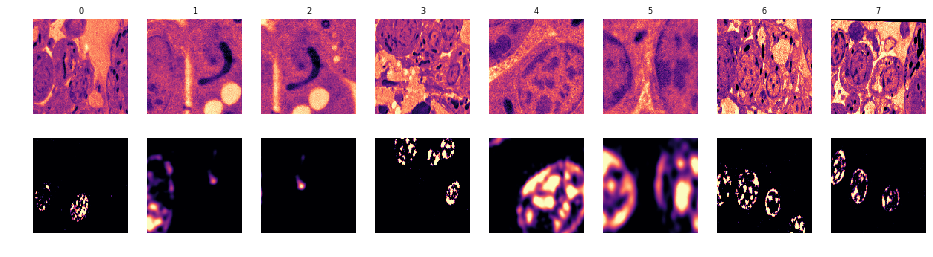

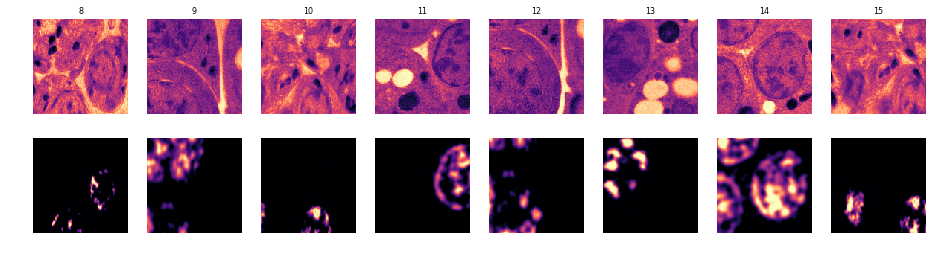

In [80]:
for i in range(2):
    plt.figure(figsize=(16,4))
    sl = slice(8*i, 8*(i+1)), 0
    plot_some(X[sl],Y[sl],title_list=[np.arange(sl[0].start,sl[0].stop)])
    plt.show()
None;